# Fast, classical gradient evaluation
$-$ now in Qiskit: [#9287](https://github.com/Qiskit/qiskit-terra/pull/9287), in collaboration with to Atsushi Matsuo and Elena Peña Tapia!

## What gradients are we talking about?

### Case 1: Ground state search

Take your favourite algorithm example, the VQE! We try to minimize the energy

$$
\mathrm{min}_\theta E(\theta) = \mathrm{min}_\theta \langle\phi(\theta)|\hat H|\phi(\theta)\rangle
$$

To minimize we can e.g. use the family of gradient-descent techniques

$$
\theta^{(k+1)} = \theta^{(k)} - \eta^{(k)} \nabla E(\theta)
$$

and this is where we need to evaluate gradients of the energy $E$.

### Case 2: Quantum time evolution

Here, we want to know how a state $|\Psi_0\rangle$ evolves in time in a system described by a Hamiltonian $H$

$$
|\Psi(t)\rangle = e^{-iHt}|\Psi_0\rangle
$$

One common algorithm on near-term devices is a variational time evolution, where we also need to compute gradients! (And the quantum geometric tensors, for the algorithm experts that might be familiar with this.)

### Motivation: why do simulate and why does it need speed?

![image.png](why_simulate.png)

Runtime of simulating variational quantum time evolution in Qiskit:

| number of parameters | 1 timestep | 100 timesteps|
|-|-|-|
| 10 | 0.4s | 37s |
| 100 | 3min | **6h16min** |
| 200 | 31min | **2days 3h50min**  |

## Calculating gradients in Qiskit

See also the docs: https://qiskit.org/documentation/stubs/qiskit.algorithms.gradients.html

In [1]:
from qiskit.primitives import Estimator
from qiskit.algorithms.gradients import ParamShiftEstimatorGradient

estimator = Estimator()
ps = ParamShiftEstimatorGradient(estimator)

To compute the gradient of an expectation value 

$$
\nabla \langle\phi(\theta)|H|\phi(\theta)\rangle
$$

we need a Hamiltonian $H$ and a circuit $U$ preparing $|\phi(\theta)\rangle = U(\theta)|0\rangle$:

In [103]:
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

def ising_hamiltonian(num_qubits):
    return SparsePauliOp.from_sparse_list(
        [("ZZ", [i, i + 1], 1) for i in range(num_qubits - 1)] + [("X", [i], -1) for i in range(num_qubits)],
        num_qubits=num_qubits
    )


num_qubits = 3
hamiltonian = ising_hamiltonian(num_qubits)
print(hamiltonian)

circuit = EfficientSU2(num_qubits, reps=1).decompose()
print(circuit.draw())

SparsePauliOp(['IZZ', 'ZZI', 'IIX', 'IXI', 'XII'],
              coeffs=[ 1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j, -1.+0.j])
     ┌──────────┐┌──────────┐                  ┌──────────┐ ┌──────────┐
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[3]) ├──────────■───────┤ Ry(θ[6]) ├─┤ Rz(θ[9]) ├
     ├──────────┤├──────────┤        ┌─┴─┐     ├──────────┤┌┴──────────┤
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[4]) ├──■─────┤ X ├─────┤ Ry(θ[7]) ├┤ Rz(θ[10]) ├
     ├──────────┤├──────────┤┌─┴─┐┌──┴───┴───┐┌┴──────────┤└───────────┘
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[5]) ├┤ X ├┤ Ry(θ[8]) ├┤ Rz(θ[11]) ├─────────────
     └──────────┘└──────────┘└───┘└──────────┘└───────────┘             


Now we can evaluate the gradient at some point $\theta$:

In [104]:
import numpy as np

values = np.random.random(circuit.num_parameters)

In [106]:
gradient = ps.run([circuit], [hamiltonian], [values]).result()
print(gradient.gradients[0])

[-0.0439758  -0.18706397 -1.68856954  0.02501886  0.21819397  0.21911077
 -1.08829969 -0.39258972 -0.87832711  0.13509311  0.25183051  0.23670673]


The fast, classical gradients

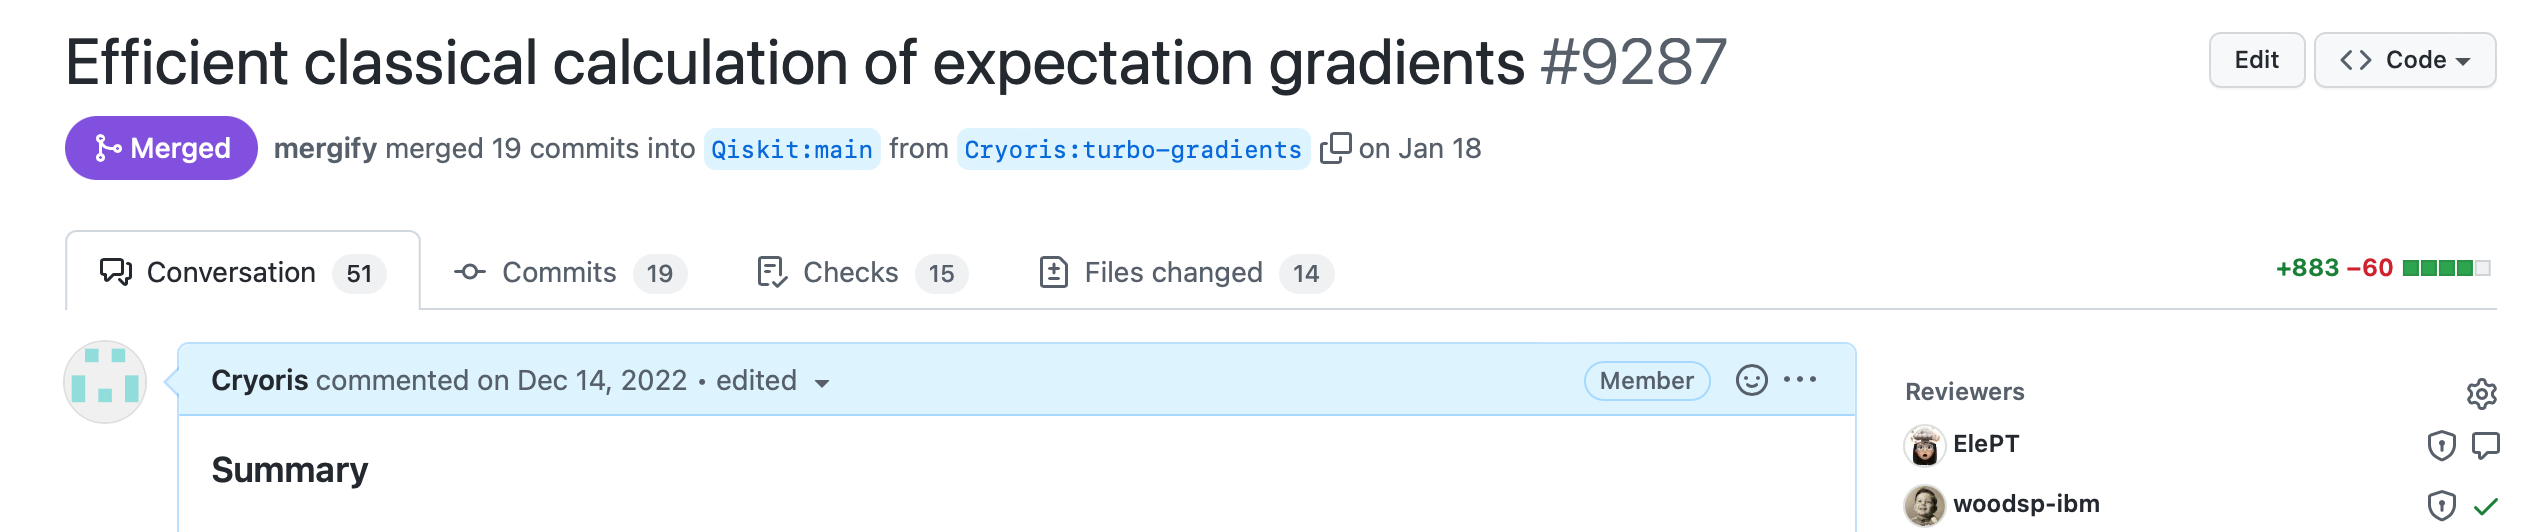

follow the same interface:

In [108]:
from qiskit.algorithms.gradients import ReverseEstimatorGradient

reverse = ReverseEstimatorGradient()  # classical calculation, not primitive-based!

In [109]:
gradient = reverse.run([circuit], [hamiltonian], [values]).result()
print(gradient.gradients[0])

[-0.0439758  -0.18706397 -1.68856954  0.02501886  0.21819397  0.21911077
 -1.08829969 -0.39258972 -0.87832711  0.13509311  0.25183051  0.23670673]


## Benchmark

In [14]:
import time
import numpy as np
from qiskit.circuit.library import EfficientSU2

def time_gradients(num_layers, gradient, num_qubits=5, averages=5):
    circuit = EfficientSU2(num_qubits, reps=num_layers).decompose()
    hamiltonian = ising_hamiltonian(num_qubits)
    values = np.linspace(1, 2, num=circuit.num_parameters)
    
    timings = []
    for _ in range(averages):
        start = time.time()
        __ = gradient.run([circuit], [hamiltonian], [values]).result()
        timings.append(time.time() - start)
        
    return np.mean(timings), np.std(timings)

In [89]:
layers = [2, 4, 6, 8, 10]
num_qubits = 5

In [90]:
ps_times = np.array([time_gradients(num_layers, ps) for num_layers in layers])

In [91]:
rev_times = np.array([time_gradients(num_layers, reverse) for num_layers in layers])

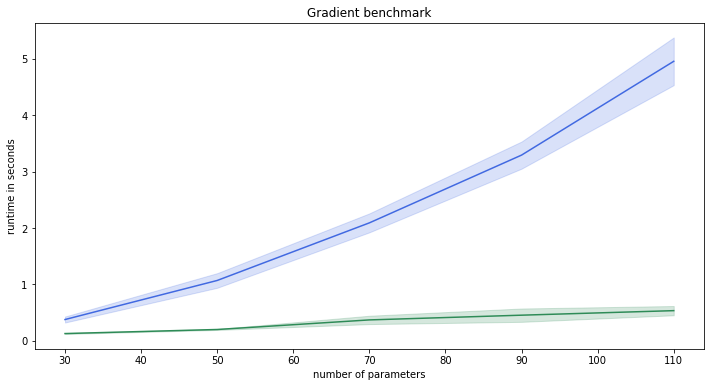

In [92]:
import matplotlib.pyplot as plt

num_parameters = (np.array(layers) + 1) * 2 * num_qubits

plt.figure(figsize=(12, 6))
plt.plot(num_parameters, ps_times[:, 0], color="royalblue", label="circuit-based")
plt.fill_between(num_parameters, ps_times[:, 0] - ps_times[:, 1], ps_times[:, 0] + ps_times[:, 1], color="royalblue", alpha=0.2)
plt.plot(num_parameters, rev_times[:, 0], color="seagreen", label="reverse")
plt.fill_between(num_parameters, rev_times[:, 0] - rev_times[:, 1], rev_times[:, 0] + rev_times[:, 1], color="seagreen", alpha=0.2)
plt.title("Gradient benchmark")
plt.xlabel("number of parameters")
plt.ylabel("runtime in seconds");

## Example 1: VQE 

Benchmark the VQE on a 4-qubit Ising model with an ``EfficientSU2`` circuit with varying depth.

In [62]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.time_evolvers.variational import RealMcLachlanPrinciple

def time_vqe(num_layers, gradient, num_qubits=4):
    circuit = EfficientSU2(num_qubits, reps=num_layers).decompose()
    hamiltonian = ising_hamiltonian(num_qubits)
    
    optimizer = GradientDescent(maxiter=100)
    initial_point = np.zeros(circuit.num_parameters)
    vqe = VQE(estimator, circuit, optimizer, gradient=gradient, initial_point=initial_point)
    
    start = time.time()
    _ = vqe.compute_minimum_eigenvalue(hamiltonian)
    took = time.time() - start
    print("done in", took)
    return took

Here we increase the number of layers to add more parameters (which we would e.g. do to increase accuracy).

In [79]:
num_qubits = 4
layers = [2, 4, 6, 8, 10, 12]
num_parameters = (np.array(layers) + 1) * 2 * num_qubits

In [74]:
vqe_ps_times = np.array([time_vqe(num_layers, ps) for num_layers in layers])
# vqe_ps_times = np.load("vqe_ps_times.npy")

done in 284.5793550014496
done in 362.38935899734497


In [ ]:
vqe_rev_times = np.array([time_vqe(num_layers, reverse) for num_layers in layers])
# vqe_rev_times = np.load("vqe_rev_times.npy")

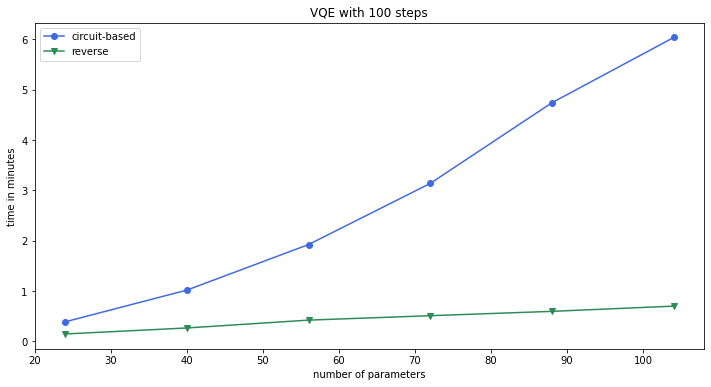

In [87]:
plt.figure(figsize=(12, 6))
plt.plot(num_parameters, vqe_ps_times / 60, color="royalblue", marker="o", label="circuit-based")
plt.plot(num_parameters, vqe_rev_times / 60, color="seagreen", marker="v", label="reverse")
plt.legend(loc="best")
plt.title("VQE with 100 steps")
plt.xlabel("number of parameters")
plt.ylabel("time in minutes");

## Example 2: Quantum time evolution

Now we benchmark the real time evolution of the same Ising model for an evolution time of $T=1$ and 100 timesteps.

In addition to the gradients, this also requires the Quantum Geometric Tensor, which can be seen as a Hessian (i.e. 2nd order derivative). The PR above also implemented the same classical algorithm for this higher order gradient:

In [93]:
from qiskit.algorithms.gradients import ReverseQGT

Let's benchmark!

In [53]:
from qiskit.algorithms.time_evolvers import VarQRTE, TimeEvolutionProblem
from qiskit.algorithms.time_evolvers.variational import RealMcLachlanPrinciple

def time_varqte(num_layers, estimator, gradient, qgt, num_qubits=5, averages=1):
    circuit = EfficientSU2(num_qubits, reps=num_layers).decompose()
    hamiltonian = ising_hamiltonian(num_qubits)
    problem = TimeEvolutionProblem(hamiltonian, time=1)#, aux_operators=[hamiltonian])
    
    principle = RealMcLachlanPrinciple(qgt, gradient)
    initial_values = np.zeros(circuit.num_parameters)
    varqte = VarQRTE(circuit, initial_values, principle, estimator=estimator, num_timesteps=100)
    
    start = time.time()
    _ = varqte.evolve(problem)
    took = time.time() - start
    print("done in", took)
        
    return took

Here, we need a different kind of circuit-based gradient than the Parameter Shift as we here need to compute the imaginary part of the gradient. The `LinCombEstimatorGradient` supports this calculation.

In [25]:
from qiskit.algorithms.gradients import LinCombEstimatorGradient, LinCombQGT

In [96]:
num_qubits = 4
layers = [2, 4, 6, 8]
num_parameters = (np.array(layers) + 1) * 2 * num_qubits

In [100]:
lcu_qgt = LinCombQGT(estimator)
lcu = LinCombEstimatorGradient(estimator)

# varqte_times = np.array([time_varqte(num_layers, estimator, lcu, lcu_qgt) for num_layers in layers])
varqte_times = np.load("varqte_times.npy")

In [101]:
rev_qgt = ReverseQGT()

# revqte_times = np.array([time_varqte(num_layers, estimator, reverse, rev_qgt) for num_layers in layers])
revqte_times = np.load("revqte_times.npy")

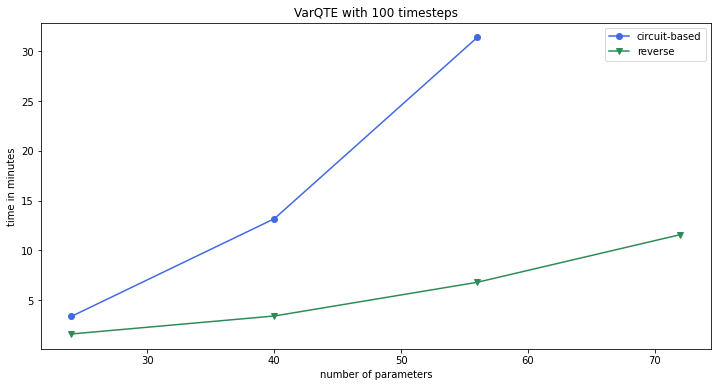

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(num_parameters[:len(varqte_times)], varqte_times / 60, color="royalblue", marker="o", label="circuit-based")
plt.plot(num_parameters, revqte_times / 60, color="seagreen", marker="v", label="reverse")
plt.legend(loc="best")
plt.title("VarQTE with 100 timesteps")
plt.xlabel("number of parameters")
plt.ylabel("time in minutes");

# Take-home message

Simulations are an important step in the algorithm pipeline, and the classical gradients make things go fast and allow us to test on larger systems. 

**Note:** So far, they only work for shot-free, statevector simulations.

# Further improvements

* Generalize the gradients for the `SamplerGradient`, used e.g. in machine learning.
* Emulate shot-noise to speed up shot-based simulations.